# Auto NER 
Pipeline to detect specimen codes in article text

* Sources: UMMZ papers
* Labels: automatically extracted and verified with pattern matching

Steps:
1. **Make training data**: extract sentences matching upper/digit pattern to label
2. **Train NER model**: apply labels to train transformer-based model to detect `SPECIMEN` entities
3. **Apply NER model**: extract references to `SPECIMEN` entities in UMMZ Bibliography

## 1. Make training data
Prepare training data from UMMZ Bibliography. Does not require accelerator (GPU).

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import re
import glob
import random
from random import sample
import json
# import jsonlines
import pysbd
seg = pysbd.Segmenter(language="en", clean=False)
import spacy
from spacy.matcher import Matcher
from spacy import displacy

Define rule-based pattern (UPPER, DIGIT) to find sentences to label

In [2]:
nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)
pattern = [{'IS_UPPER': True}, {'IS_DIGIT': True}] # token sequence has uppercase followed by digit
matcher.add("specimen_code", [pattern])

Helper functions for parsing json documents

In [3]:
def clean_text(txt):
    """
    Removes special characters, punctuation, and returns lowercase
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

def clean_text2(txt):
    """
    Removes special characters and punctuation
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt))

def alphanum(txt):
    """
    Extracts alphanumeric characters without spaces
    """
    return "".join(x.lower() for x in txt if x.isalnum())

def extract_pat(search_str:str, search_list:str):
    """
    Defines pattern to search for
    """
    search_obj = re.search(search_list, search_str)
    if search_obj:
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = "None"
    return return_str

def json2txt_df(json_file_path):
    """
    Extract body text of json file
    """
    with open(json_file_path, 'r') as f:
        data = json.loads(f.read())
        body_text_df = pd.json_normalize(data["pdf_parse"]["body_text"])
    
    return body_text_df

def df2sentences(df):
    """
    Tokenize and clean sentences
    """
    sentences_text = " ".join(list(df.text)) 
    pattern_brackets = re.compile(r'\(.*?\)')
    sentences_text = re.sub(pattern_brackets, "", sentences_text) 
    sentences = seg.segment(sentences_text) 
    sentences = [re.sub(r"^\W+", "", sentence) for sentence in sentences] 
    sentences = [re.sub(r"\s+", " ", sentence) for sentence in sentences]
    return sentences

def prep_data(json_file_path, ref_id):
    """
    Return sentence lists for matches
    """
    body_text_df = json2txt_df(json_file_path)
    sentences = df2sentences(body_text_df)
    candidates = []
    for sentence in sentences:
        doc = nlp(sentence)
        matches = matcher(doc)
        if len(matches) > 0:
            sentence_dict = {"text":sentence,
                             "meta":{"ref_id":str(ref_id)}}
            candidates.append(sentence_dict)    
    return candidates

Project directories
- Articles in UMMZ Bibliography (646 papers, 45% as of May 17, 2022)

In [4]:
# papers_path = "/nfs/turbo/isr-slafia/specimen/may_zotero_ummz_out/"
# save_path = "/nfs/turbo/isr-slafia/specimen/may_zotero_ummz_sents/"

Check each sentence for pattern. If it matches, get the sentence and file name. 

In [5]:
# %%time

bib_files = sorted(glob.glob('../papers/*.json'))
print(f"Searching {len(bib_files)} papers for specimen codes")

# for bib_file in bib_files:
#     ref_id = bib_file.split("/")[-1].split("-")[0]
#     try: 
#         sentence_dicts_list = prep_data(bib_file, ref_id)
#         print(ref_id) # show file name for the match
#         with jsonlines.open(save_path+'/ummz_pattern_matching_20220705.jsonl', 'a') as writer:
#             writer.write_all(sentence_dicts_list)
#     except:
#         0

Searching 828 papers for specimen codes


Export matching sentences and metadata (source file name) for labeling offline
* It took 2 hours to label 1,010/3,953 sentences on a local machine
* Labeling rules:
    * Accept (positive): entity is a specimen code
    * Accept (negative): entity is not a specimen code
    * Ignored: sentence is malformed, not enough context for training
* Sources of confusion:
    * software, sequencing techniques (ABI3700), state/postal codes, p values (P2), null hypothesis (H0), compounds (CO2), grant numbers, coordinate reference system (WGS84), dates (AD1200), legislation (HB117), metadata (ISO2788)
    * spans or compound codes (TMM 45947-506 and -510)
    * tokenization and sentence fragments from scientific notation
    * unlikely documents in bibliography (Advances in Computation… President’s Comments and Report…)
* Approach: [Manual NER in Prodigy](https://prodi.gy/docs/recipes#ner-manual) labeling using a pattern template
    * Pattern template: {"label": "SPECIMEN", "pattern": [{"is_upper": true}, {"is_digit": true}]}
    * Prodigy recipe: prodigy ner.manual ummz_v1 en_core_web_sm ./ummz_pattern_matching.jsonl --label SPECIMEN --patterns ./specimen_pattern_V1.jsonl
    * Export training/dev data from Prodigy: prodigy data-to-spacy train --ner ummz_v1

In [6]:
training_data = open('../labels/auto/ummz_pattern_matching.jsonl')
read_data = training_data.read()
per_word = read_data.split()

print('Candidate sentences found:', sum(1 for line in open('../labels/auto/ummz_pattern_matching.jsonl')))
print('Term fraction - UMMZ:', (read_data.count("UMMZ")/len(per_word))*100)
print('Term fraction - specimen:', (read_data.count("specimen")/len(per_word))*100)
print('Term fraction - fossil:', (read_data.count("fossil")/len(per_word))*100)
print('Term fraction - occurrence:', (read_data.count("occurrence")/len(per_word))*100)

Candidate sentences found: 3953
Term fraction - UMMZ: 0.020798420276308207
Term fraction - specimen: 0.3158013009770476
Term fraction - fossil: 0.08438899261536549
Term fraction - occurrence: 0.018407797256042895


## 2. Train NER model to detect custom entity
Detect `SPECIMEN` using [spaCy](https://spacy.io/usage/embeddings-transformers). Requires accelerator (used GPU: cuda/11.2.1)

In [7]:
import spacy

In [8]:
print(spacy.__version__)

3.3.1


In [9]:
spacy.require_gpu()

## Train and save NER model
Use command-line interface (CLI) so program sources spaCy correctly

In [10]:
# !python -m spacy train ../models/config.cfg --output ../models/auto/ --paths.train ../models/auto/train.spacy --paths.dev ../models/auto/dev.spacy --gpu-id 0

## 3. Apply NER model
Apply current best NER model to all UMMZ papers collected so far

In [4]:
# from thinc.api import set_gpu_allocator, require_gpu
# set_gpu_allocator("pytorch")
# require_gpu(0)

In [7]:
# spacy.prefer_gpu()

In [13]:
custom_ner_model = spacy.load("../models/auto/model-best/")

In [14]:
%%time

ummz_papers = glob.glob('../papers/*.json')
print(f"Looking for SPECIMEN entities in {len(ummz_papers)} UMMZ papers")

df_test_pubs = pd.DataFrame()
for test_file in ummz_papers:
    with open(test_file, 'r') as f:
        data = json.loads(f.read())
        file_data = pd.json_normalize(data["pdf_parse"]["body_text"])
        file_data["paper_id"] = data["title"]
    df_test_pubs = pd.concat([df_test_pubs, file_data])

ummz_sentences = []

for row in df_test_pubs.itertuples():
    for sent in seg.segment(row[1]):
        ummz_sentences.append((row[7], row[5], row[7], sent))
        
df_ummz_sent = pd.DataFrame(ummz_sentences, columns=['Id', 'section_title', 'paper_title', 'sent'])
df_ummz_sent['sent'] = df_ummz_sent['sent'].astype(str)

def extract_ents(text):
    """
    Extract named entities, and beginning, middle and end idx     
    """
    doc = custom_ner_model(text)
    if len(doc.ents) > 0:
        return clean_text2(doc.ents)
    else:
        return None

def predict_ents(df):
    """
    Create new column in data frame with named entity tuple extracted
    """
    df_ummz_sent['specimen_prediction'] = df_ummz_sent['sent'].apply(extract_ents)
    
predict_ents(df_ummz_sent)

df_ummz_sent['specimen_prediction'].value_counts().sort_values(ascending=False)


Looking for SPECIMEN entities in 828 UMMZ papers


/sw/arcts/centos7/python/3.9.7/pytorch/1.10.2/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


CPU times: user 8h 38min 7s, sys: 1min 59s, total: 8h 40min 6s
Wall time: 17h 23min 14s


 AL 288                     75
 NO                         67
 AMNH                       31
 PAUP                       26
 TXNM                       26
                            ..
 AMNH 46627 AMNH 46643       1
 AMNH 46629                  1
 FMNH 43246 BMNH 54 553      1
 FMNH 43251                  1
 ELK1                        1
Name: specimen_prediction, Length: 3998, dtype: int64

Demonstrate model predictions with a randomly sampled paper in the UMMZ bibliography

In [15]:
%%time

papers_sample = random.sample(ummz_papers, 1)

for file in papers_sample:
    ref_id = file.split("/")[-1].split("-")[0]
    print(f"Searching for SPECIMEN entities in paper: {ref_id}")
    body_text_df = json2txt_df(file)
    sentence_list = df2sentences(body_text_df)
    for sentence in sentence_list:
        clean_sent = clean_text2(sentence)
        doc = custom_ner_model(clean_sent)
        if len(doc.ents) > 0:
            displacy.render(doc, style="ent", jupyter=True)

Searching for SPECIMEN entities in paper: Sancha2012_Article_SystematicsOfTheSubgenusOfMous.json


/sw/arcts/centos7/python/3.9.7/pytorch/1.10.2/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


CPU times: user 13.8 s, sys: 26 ms, total: 13.9 s
Wall time: 27.8 s


Top, unique entities across papers in available papers in UMMZ Bibliogrpahy

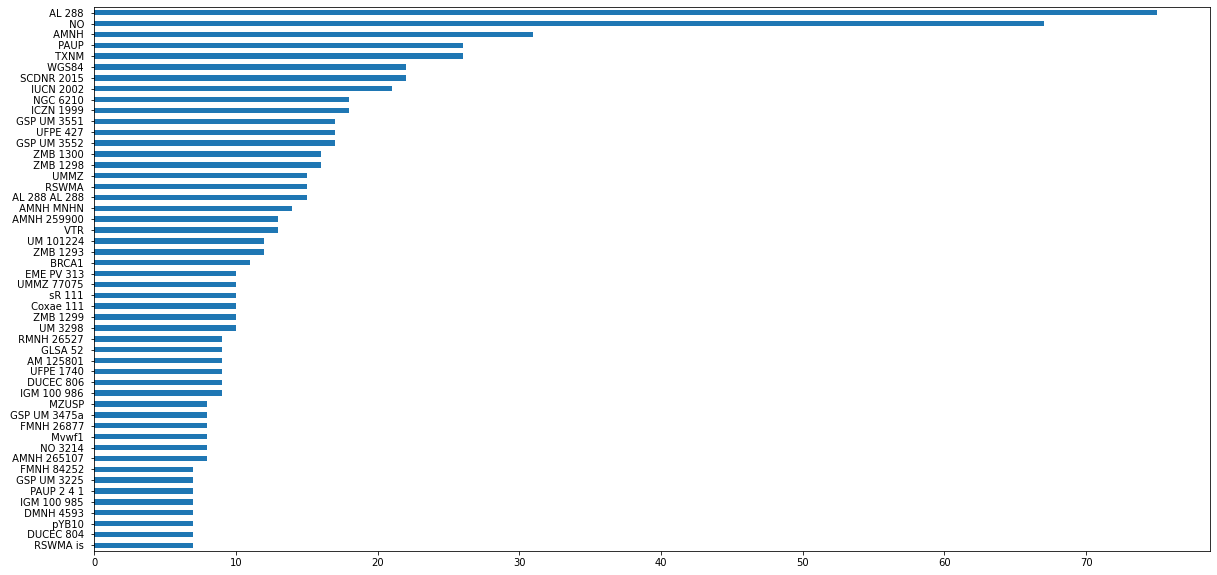

In [18]:
ax = df_ummz_sent['specimen_prediction'].value_counts().nlargest(50).sort_values().plot(kind='barh',figsize=(20,10))
# ax.figure.savefig('../results/auto_count.png', dpi=300)


In [19]:
ummz_unique_codes = set(df_ummz_sent['specimen_prediction'].unique())
len(ummz_unique_codes)


3999

In [20]:
predictions_ummz = df_ummz_sent[df_ummz_sent.specimen_prediction.notna()]
predictions_ummz = predictions_ummz[predictions_ummz.Id.notna()]
predictions_ummz['paper'] = predictions_ummz['Id'].astype("category").cat.codes

predictions_ummz['Id'] = predictions_ummz[['Id','paper','specimen_prediction']].groupby(['specimen_prediction','paper'])['Id'].transform(lambda x: ','.join(x))
predictions_ummz.to_csv('../results/auto_predictions.csv',index=False)
predictions_ummz.head()

,Id,section_title,paper_title,sent,specimen_prediction,paper
41,,"Isothrix barbarabrownae, new species",,"-MUSM 16819 (Museo de Historia Natural, Univer...",MUSM 16819,0
170,The Smithsonian Institution African Mammal Pro...,,The Smithsonian Institution African Mammal Pro...,NMNH voucher specimens of Rodentia resulting f...,NMNH voucher specimens,313
173,The Smithsonian Institution African Mammal Pro...,,The Smithsonian Institution African Mammal Pro...,5. NMNH voucher specimens of Chiroptera result...,NMNH voucher,313
203,The Smithsonian Institution African Mammal Pro...,Data Sources and General Format of the Gazetteer,The Smithsonian Institution African Mammal Pro...,"The project started in 1969, one of the earlie...",SELGEM SELGEM 1988,313
334,The Smithsonian Institution African Mammal Pro...,ACKNOWLEDGMENTS,The Smithsonian Institution African Mammal Pro...,"Several former AMP collectors-Ron E. Cole, Ric...",AMP collectors,313


In [21]:
predictions_ummz_dedup = predictions_ummz[['specimen_prediction','Id','paper']].drop_duplicates()
cross_df = pd.crosstab(predictions_ummz_dedup.specimen_prediction, predictions_ummz_dedup.paper, margins=True, dropna=False)
cross_df.to_csv('../results/auto_frequencies.csv')
cross_df.head()

paper,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,All
specimen_prediction,,,,,,,,,,,,,,,,,,,,,
13O 37,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14 AKKXI Alet t,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
171408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
194816 specimens AMNH 95206 USNM 194785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2N 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
